# Exercise 4

Implement Polyak's heavy ball and Nesterov's accelerated gradient method. Run it on some example problems and compare the running times with the gradient descent with backtracking line search. In the two-dimensional case, plot some contour plots.

### Utilities

In [1]:
# Importing libraries

from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy.typing import NDArray
from sklearn.datasets import make_classification, make_regression
from scipy.optimize import minimize
from timeit import default_timer as clock

In [2]:
def contour_map(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
    ax=None,
) -> None:
    """Plots the contour lines of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
        ax (optional): The axes to plot on. Defaults to None.
    """
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.contour(xv, yv, values.reshape(nx, ny), 15)


def surface_plot(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
) -> tuple[plt.Figure, Axes3D]:
    """Creates a 3D surface plot of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
    Returns:
        tuple[plt.Figure, Axes3D]: Figure and axis containing the rendered surface.
    """
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.plot_surface(xv, yv, values.reshape(nx, ny), cmap=cm.coolwarm)
    return fig, ax

In [3]:
def backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 0.3,
    beta: float = 0.8,
) -> float:
    """Performs Armijo backtracking line search for a descent direction.

    Args:
        x (NDArray): Current point in parameter space.
        d (NDArray): Candidate descent direction.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        alpha (float, optional): Armijo sufficient decrease parameter. Defaults to 0.3.
        beta (float, optional): Multiplicative shrink factor for the step size. Defaults to 0.8.
    Returns:
        float: Step length that satisfies the Armijo condition.
    """
    step_size = 1.0
    fx = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)

    while f(x + step_size * d) > fx + alpha * step_size * directional_derivative:
        step_size *= beta

    return step_size

def gradient_descent_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Collects iterates produced by gradient descent.

    Args:
        x0 (NDArray): Initial point used to seed the algorithm.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        max_iter (int, optional): Maximum number of gradient steps. Defaults to 100.
    Returns:
        list[NDArray]: Sequence of iterates, including the initial point.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        grad = g(x)
        step = backtracking_line_search(x, -grad, f, g)
        x = x - step * grad
        xs.append(x.copy())
    return xs

In [4]:
EXAMPLE_MATRIX = np.array([[30.0, 15], [-20, 25]]) / 20

EXAMPLES = [
    (
        lambda x: x.T @ EXAMPLE_MATRIX @ x + 1,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T) @ x,
        0.5 * np.ones(2),
        (-1.0, 1.0),
        (-1.0, 1.0),
    ),
    (
        lambda x: (x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]),
        lambda x: np.array([2 * x[0] + 4, 60 * x[1]]),
        np.array([2.0, 3.0]),
        (-2.5, 2.5),
        (-1.5, 3.5),
    ),
    (
        lambda x: np.linalg.norm(np.sin(x * 3)) ** 2,
        lambda x: 6 * np.sin(x * 3) * np.cos(x * 3),
        np.array([0.3, 0.5]),
        (-1.5, 1.0),
        (-1.0, 1.0),
    ),
]

optimizer_path_function_type = Callable[[NDArray, Callable[[NDArray], float], Callable[[NDArray], NDArray]], list[NDArray]]

def run_examples(optimizer_1: optimizer_path_function_type, optimizer_name_1: str, optimizer_2: optimizer_path_function_type, optimizer_name_2: str) -> None:
    """Compares two optimizers on examples

    Args:
        optimizer_1 (optimizer_path_function_type): The first optimizer to compare.
        optimizer_2 (optimizer_path_function_type): The second optimizer to compare.
    """
    for f, g, x0, x_bounds, y_bounds in EXAMPLES:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        xs_1 = np.array(optimizer_1(x0, f, g))
        xs_2 = np.array(optimizer_2(x0, f, g))

        contour_map(f, xb=x_bounds, yb=y_bounds, ax=axs[0])

        axs[0].plot(xs_1[:, 0], xs_1[:, 1], ".--k", label=optimizer_name_1)
        axs[0].plot(xs_2[:, 0], xs_2[:, 1], ".--", color="gray", alpha=0.5, label=optimizer_name_2)

        axs[1].semilogy(np.arange(0, len(xs_1)), [f(x) for x in xs_1], label=optimizer_name_1)
        axs[1].semilogy(np.arange(0, len(xs_2)), [f(x) for x in xs_2], label=optimizer_name_2)

        axs[0].legend()
        axs[1].legend()
        axs[1].set_xlabel("iteration")
        axs[1].set_ylabel("f(x_t)")

        plt.show()

## Task 1: L-smoothness

On the exercise sheet, you have seen the following lemma:
**Lemma**
For all matrices $A \in \mathbb{R}^{n\times m}$
$$
\|A\|_2 \leq \|A\|_F
$$
where $\|A\|_2$ is the spectral norm and $\|A\|_F$ is the Frobenius norm of matrix $A$.

Use the lemma to approximate the constant $L$ of the function
$$
f(x) = \|Ax - b\|_2^2
$$
for the given matrices $A$ and vectors $b$ below.
Compute also the true $L$ constant.

Measure the time it takes to compute both constants.
Do the results align with your knowledge of the computational complexity of both norms?

In [5]:
def approximate_spectral_norm(A: NDArray) -> float:
    """Approximates the spectral norm of a matrix.

    Args:
        A (NDArray): The input matrix.

    Returns:
        float: The approximated spectral norm.
    """
    # TODO: Compute the spectral norm using the approximation from the lemma
    # raise NotImplementedError
    return np.linalg.matrix_norm(A, ord='fro')

In [6]:
def exact_spectral_norm(A: NDArray) -> float:
    """Computes the exact spectral norm of a matrix.

    Args:
        A (NDArray): The input matrix.

    Returns:
        float: The exact spectral norm.
    """
    # TODO: Compute the spectral norm accurately
    # raise NotImplementedError
    return np.linalg.norm(A, ord=2)

In [7]:
rng = np.random.default_rng(seed=0)

functions_parameters = [
    (
        np.array(
            [
                [1, 2, 0],
                [2, 2, -1],
                [2, 1, 1],
                [10, 0, -1],
                [0, 0, 10],
                [-1, -2, -1],
                [-3, -2, -1],
            ]
        ),
        np.array([[1, 1, 1, 0, 0, 0, 0]]),
    ),
    (
        rng.normal(1.0, 2.0, size=(10000, 4000)),
        np.ones(10000),
    ),
]

for A, b in functions_parameters:
    # TODO: Define the matrix whose spectral norm is the L constant of the function
    H = 2 * A.T @ A

    start = clock()
    print(f"L computed exactly       is {exact_spectral_norm(H):2,.2f}. Computation took {clock() - start:2,.6f} seconds.")

    start = clock()
    print(f"L computed approximately is {approximate_spectral_norm(H):2,.2f}. Computation took {clock() - start:2,.6f} seconds.")

    print()

L computed exactly       is 246.24. Computation took 0.000434 seconds.
L computed approximately is 322.97. Computation took 0.000062 seconds.

L computed exactly       is 80,112,067.56. Computation took 35.634086 seconds.
L computed approximately is 80,335,420.63. Computation took 0.083246 seconds.



## Task 2: Running time

On the exercise sheet, you compared asymptotic convergence rates of gradient descent and the optimal method.

For gradient descent, we have a convergence rate of $O((1 - \frac{1}{Q_f})^T)$, while for the optimal method, we have a convergence rate of $O((1 - \frac{1}{\sqrt{Q_f}})^T)$, with $Q_f := \frac{L}{\mu}$.

- Plot the convergence rate over time for $Q_f = 10^4$ (assume big-O constants are 1).
- Plot the convergence rate per step as a function of $Q_f$ (assume big-O constants are 1).
- Plot the ratio of the number of iterations needed by gradient descent and the optimal method to reach a certain accuracy as a function of $Q_f$ (assume big-O constants are 1 and epsilon = 0.01).

C:\Users\admin\AppData\Local\Temp\ipykernel_7076\770355812.py:47: RuntimeWarning: divide by zero encountered in log
  T_GD = np.log(epsilon) / np.log(1 - 1 / qf)
C:\Users\admin\AppData\Local\Temp\ipykernel_7076\770355812.py:48: RuntimeWarning: divide by zero encountered in log
  T_opt = np.log(epsilon) / np.log(1 - 1 / np.sqrt(qf))
C:\Users\admin\AppData\Local\Temp\ipykernel_7076\770355812.py:50: RuntimeWarning: invalid value encountered in divide
  ratio = T_GD / T_opt


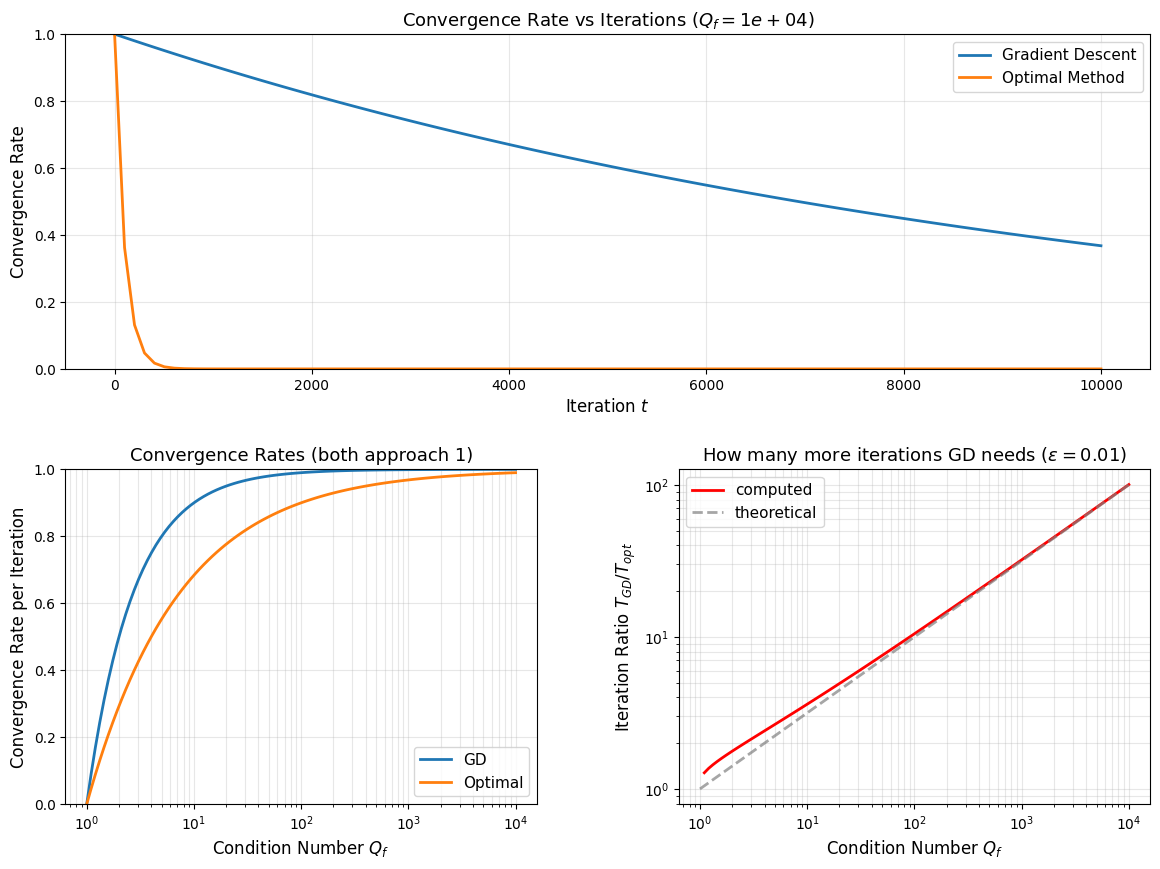

In [8]:
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Top plot: Convergence rate over iterations for Q_f = 10^4
ax0 = fig.add_subplot(gs[0, :])
step_size = np.linspace(0, 10000, 100)
Q_f = 10**4

# TODO: Compute the convergence rates of gradient descent and the optimal method
gd_convergence = (1 - 1 / Q_f) ** step_size
opt_convergence = (1 - 1 / np.sqrt(Q_f)) ** step_size

ax0.plot(step_size, gd_convergence, linewidth=2, label="Gradient Descent")
ax0.plot(step_size, opt_convergence, linewidth=2, label="Optimal Method")
ax0.set_xlabel('Iteration $t$', fontsize=12)
ax0.set_ylabel('Convergence Rate', fontsize=12)
ax0.set_title(f'Convergence Rate vs Iterations ($Q_f = {Q_f:.0e}$)', fontsize=13)
ax0.legend(fontsize=11)
ax0.grid(True, alpha=0.3)
ax0.set_ylim((0.0, 1.0))

# Bottom left: Convergence rates
ax1 = fig.add_subplot(gs[1, 0])

qf = np.logspace(0, 4, 100)

# TODO: Compute the per-step convergence rates of gradient descent and the optimal method
gd_per_step_convergence = 1 - 1 / qf
opt_per_step_convergence = 1 - 1 / np.sqrt(qf)

ax1.semilogx(qf, gd_per_step_convergence, linewidth=2, label="GD")
ax1.semilogx(qf, opt_per_step_convergence, linewidth=2, label="Optimal")
ax1.set_xlabel('Condition Number $Q_f$', fontsize=12)
ax1.set_ylabel('Convergence Rate per Iteration', fontsize=12)
ax1.set_title('Convergence Rates (both approach 1)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')
ax1.set_ylim((0.0, 1.0))

# Bottom right: Ratio of iterations needed
ax2 = fig.add_subplot(gs[1, 1])

qf = np.logspace(0, 4, 100)
epsilon = 0.01

# TODO: Compute the number of iterations needed to reach accuracy epsilon for gradient descent and the optimal method
T_GD = np.log(epsilon) / np.log(1 - 1 / qf)
T_opt = np.log(epsilon) / np.log(1 - 1 / np.sqrt(qf))

ratio = T_GD / T_opt
# TODO: Compute the  theoretical ratio from the exercise
theoretical_ratio = np.sqrt(qf)

ax2.loglog(qf, ratio, linewidth=2, label="computed", color='red')
ax2.loglog(qf, theoretical_ratio, '--', linewidth=2, label="theoretical", color='gray', alpha=0.7)
ax2.set_xlabel("Condition Number $Q_f$", fontsize=12)
ax2.set_ylabel("Iteration Ratio $T_{GD}/T_{opt}$", fontsize=12)
ax2.set_title(f"How many more iterations GD needs ($\\epsilon = {epsilon}$)", fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

plt.show()

## Task 3: Polyak's heavy ball method

Implement Polyak's heavy ball method and the coresponding line search. **Standard backtracking line search is not usable here.**
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `heavy_ball_path` should return a list of vectors on the path to the minimum.

In [9]:
from numpy.typing import NDArray
from typing import Callable
import numpy as np

def non_descent_backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 1.0,
    beta: float = 0.8,
) -> float:
    """Line search for methods that do not guarantee a descent direction.
    Finds a step size that satisfies a modified sufficient decrease condition.

    Args:
        x (NDArray): The current point.
        d (NDArray): The search direction (not necessarily a descent direction).
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        alpha (float, optional): The parameter of the modified sufficient decrease condition. Defaults to 0.3.
        beta (float, optional): The factor by which to reduce the step size per iteration. Defaults to 0.8.

    Returns:
        float: The step size that satisfies the modified sufficient decrease condition.
    """
    # TODO: Implement backtracking line search that can handle non-descent directions
    step_size = 1.0
    fx: float = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)
    while f(x + step_size * d) > fx + alpha * step_size * directional_derivative + step_size / 2 * d.T @ d:
        step_size *= beta
        
    return step_size

In [10]:
def heavy_ball_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the Heavy Ball method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement the Heavy Ball method
    # raise NotImplementedError

    # print(x0)
    x = np.array(x0, dtype=float, copy=True)
    # print(x)
    xs = [x.copy()]
    # print(xs)
    xp = x.copy()

    beta = 0.8

    for i in range(max_iter):
        beta = (i - 1) / (i + 1)
        grad = g(x)
        d = -grad + beta * (x-xp)
        step_size = non_descent_backtracking_line_search(x, d, f, g)
        xp = x.copy()
        x += step_size * d
        xs.append(x.copy())        

    return xs

In [ ]:
def heavy_ball_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the Heavy Ball method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement the Heavy Ball method

    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        d = -g(current_x) + (i - 1) / (i + 1) * (current_x - prev_x)
        t = non_descent_backtracking_line_search(current_x, d, f, g)
        xs.append(current_x + t * d)

    return xs

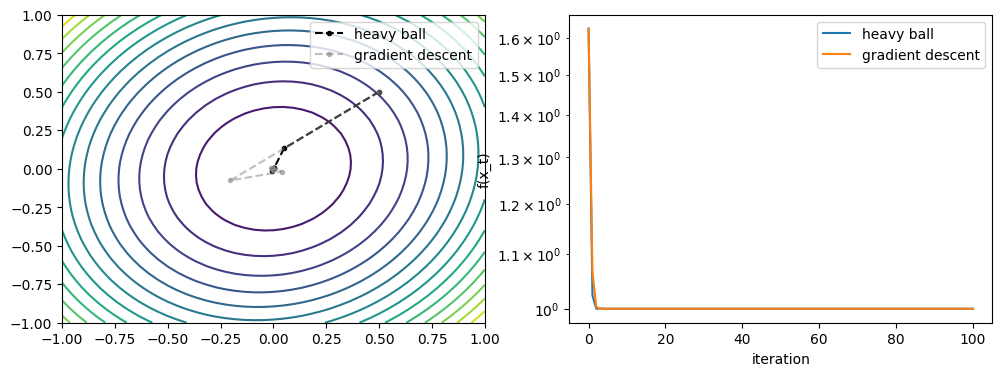

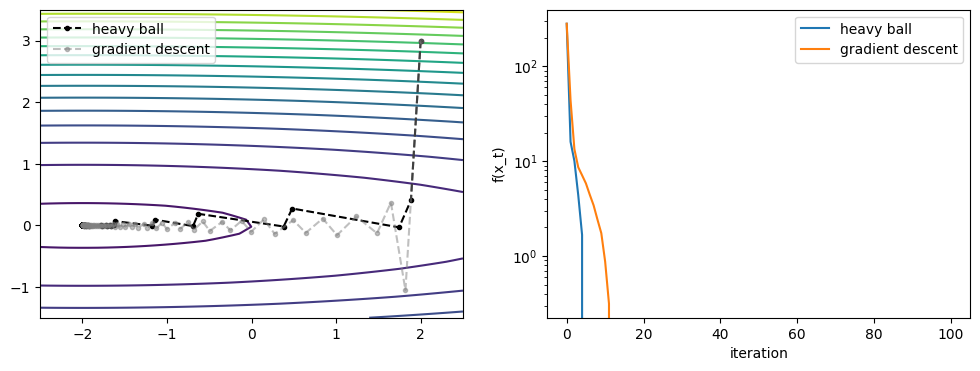

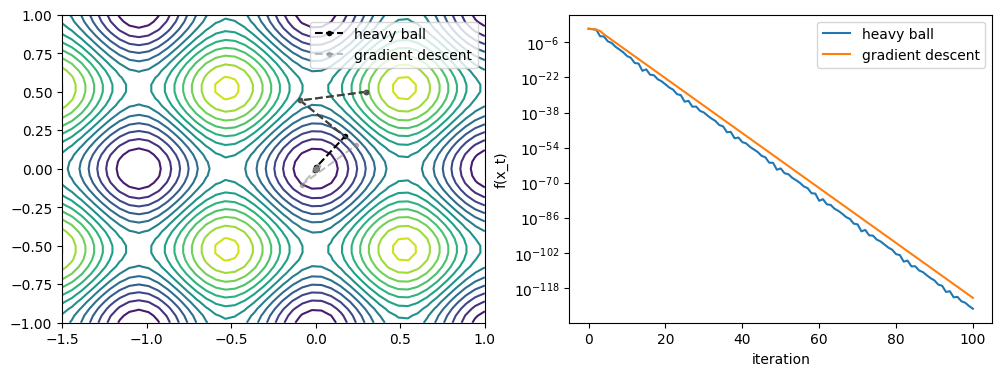

In [11]:
# run this to get plots
run_examples(heavy_ball_path, "heavy ball", gradient_descent_path, "gradient descent")

## Task 4: Nesterov accelerated gradient method and backtracking line search

Implement Nesterov's accelerated gradient method and the corresponding line search. **Standard backtracking line search is not usable here.**

* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `nag_path` should return a list of vectors on the path to the minimum.

In [12]:
def nag_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Nesterov's accelerated gradient method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement Nesterov's accelerated gradient method
    # raise NotImplementedError
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    xp = x.copy()
    
    beta = 1.0  # Momentum parameter

    for i in range(max_iter):
        beta = (i-1)/(i+2)
        y = x + beta * (x-xp)
        grad = g(y)
        d = grad # d = -grad + beta * (x-xp)
        xp = x.copy()
        # x = y - non_descent_backtracking_line_search(y, d, f, g) * grad
        x = y - non_descent_backtracking_line_search(y, -d, f, g) * d
        xs.append(x.copy())
        
    return xs

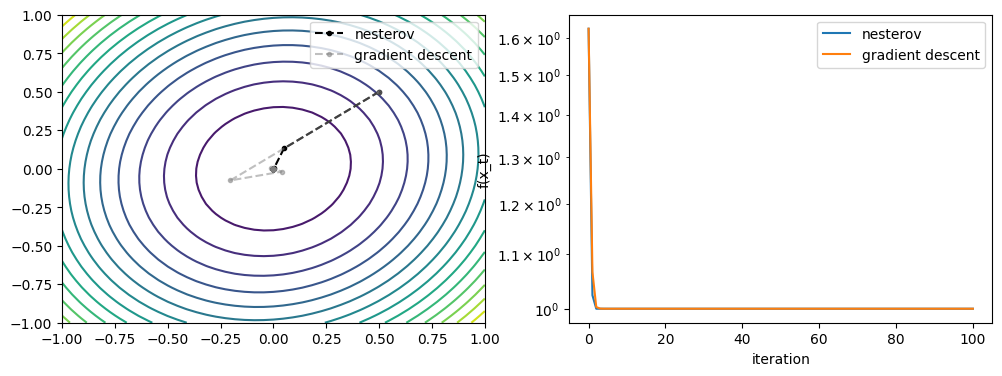

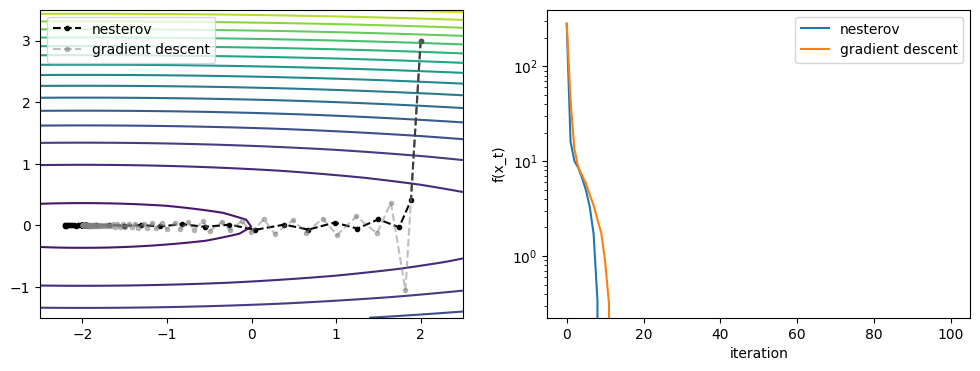

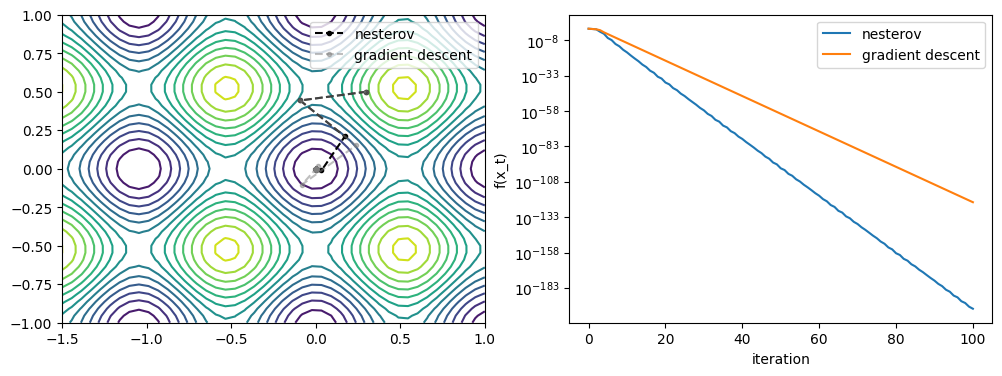

In [13]:
run_examples(nag_path, "nesterov", gradient_descent_path, "gradient descent")

## Task 5: Error plots

Compare and plot the error over time for the three methods on the following tasks.

In [14]:
def plot_error(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    x_star: NDArray,
) -> None:
    """Compares the difference between optimum and function value along the paths of gradient descent, heavy ball and Nesterov's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        x_star (NDArray): The optimal solution.
    """
    ball = heavy_ball_path(x0, f, g)
    nest = nag_path(x0, f, g)
    gd = gradient_descent_path(x0, f, g)
    f_star = f(x_star)

    def errors(path: list[NDArray]) -> NDArray:
        # TODO: Compute the errors along the path
        # raise NotImplementedError
        f_values = np.array([f(x) for x in path])
        return f_values - f(x_star)

    plt.semilogy(
        np.arange(len(gd)),
        errors(gd),
        label="gradient descent",
    )
    plt.semilogy(
        np.arange(len(ball)),
        errors(ball),
        label="heavy ball",
    )
    plt.semilogy(
        np.arange(len(nest)),
        errors(nest),
        label="nesterov",
    )

    plt.legend()
    plt.show()

### Simple quadratic function

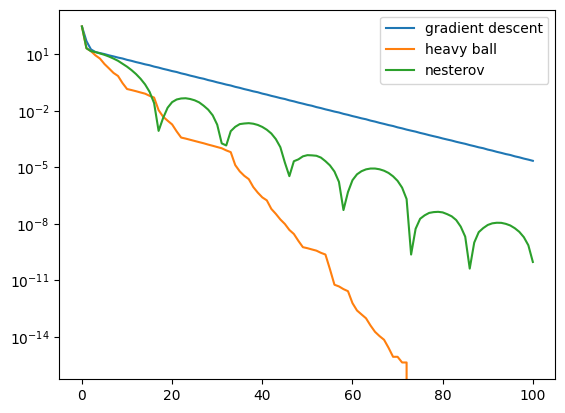

In [15]:
f = lambda x: (x[0]**2 + 30 * x[1]**2 + 4 * x[0])
g = lambda x: np.array([2 * x[0] + 4, 60 * x[1]])
x0 = np.array([2.,3.])

x_star = np.array([-2.,0.])

plot_error(x0, f, g, x_star)

### Ill-conditioned quadratic

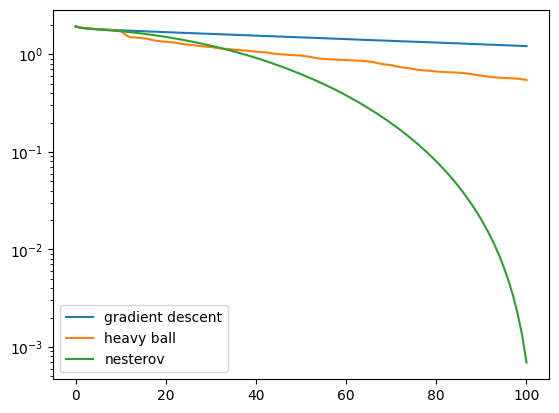

In [16]:
n = 50
rng = np.random.default_rng(seed=42)
Q = rng.standard_normal((n, n))
Q = Q.T @ Q
U, _ = np.linalg.qr(Q)

A = U @ np.diag(np.linspace(1, 1000, n)) @ U.T
b = rng.standard_normal(n)

def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x

def g(x):
    return A @ x - b

x0 = np.zeros(n)
x_star = np.linalg.solve(A, b)

plot_error(x0, f, g, x_star)

### Linear regression

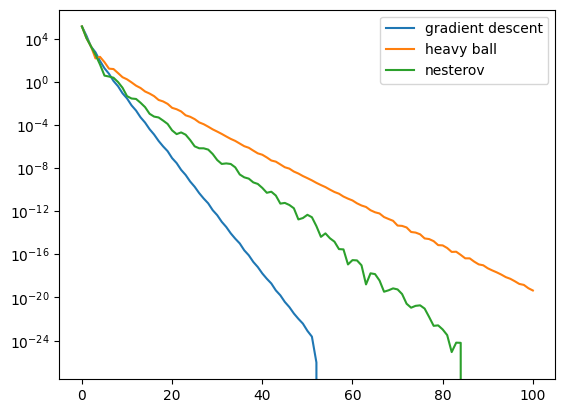

In [17]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)

def g(w):
    return 2 * X.T @ (X @ w - y) / len(X)

X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)
x0 = np.zeros(100)

x_star = np.linalg.lstsq(X, y, rcond=None)[0]

plot_error(x0, f, g, x_star)

### Logistic regression


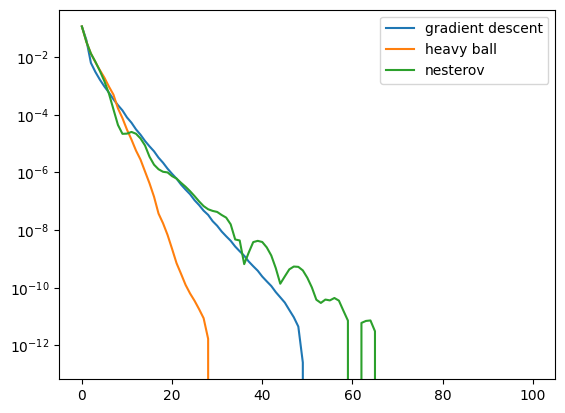

In [18]:
def f(w):
    return np.log(1.0 + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w) ** 2

def g(w):
    sig = np.exp(-y * X.dot(w))
    return 2 * w - X.T.dot(sig * y / (sig + 1.0)) / X.shape[0]

X, y = make_classification(
    1000,
    80,
    n_informative=40,
    # n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0,
)

x0 = np.zeros(80)
x_star = minimize(f, x0, jac=g).x

plot_error(x0, f, g, x_star)